# Using pre-trained NN

In [ ]:
import numpy as np
import tensorflow as tf
import keras
from matplotlib import pyplot as plt
from imageio import imread
import pickle

# Model Zoo
* https://github.com/keras-team/keras/tree/master/keras/applications
* More models within the community
* Pick model, copy init, download weights
* Here we proceed with vgg16

In [ ]:
# download vgg16 weights
!wget https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg16_weights_tf_dim_ordering_tf_kernels.h5

#### Very Deep Convolutional Networks for Large-Scale Visual Recognition
VGG at Oxford: http://www.robots.ox.ac.uk/~vgg/research/very_deep/
<br>
### [layer configuration](https://gist.githubusercontent.com/ksimonyan/211839e770f7b538e2d8/raw/0067c9b32f60362c74f4c445a080beed06b07eb3/VGG_ILSVRC_16_layers_deploy.prototxt)
Build a model based on **layer configuration** below

In [2]:
from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import MaxPool2D
from keras.layers import Activation
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten # You may need this :)


img_input = Input(shape=(224, 224, 3), name="input")
x = Conv2D(64, 3, padding="same", name="conv1_1")(img_input)

....
<!!add layers as in configuration file!!>
....

x = Activation("softmax", name="prob")(x)

model = keras.Model(img_input, x)

You have to implement two functions in the cell below.

Preprocess function should take the image with shape (w, h, 3) and transform it into a tensor with shape (1, 224, 224, 3). Without this transformation, vgg16 won't be able to digest input image. 
Additionally, your preprocessing function have to rearrange channels RGB -> BGR and subtract mean values from every channel.

In [ ]:
MEAN_VALUES = np.array([104, 117, 123])
IMAGE_W = 224

def preprocess(img):
    img = <convert RGB to BGR>
    for i in range(3):
        img = <substract mean>
        
    # convert from [w,h,3 to 1,w,h,3]
    return img[None]

def deprocess(img):
    img = img.reshape(img.shape[1:])
    for i in range(3):
        img[:,:, i] += MEAN_VALUES[i]
    return img[:, :, :: -1].astype(np.uint8)

img = (np.random.rand(IMAGE_W, IMAGE_W, 3) * 256).astype(np.uint8)

print(np.linalg.norm(deprocess(preprocess(img)) - img))

If your implementation is correct, the number above will be small, because deprocess function is the inverse of preprocess function

### Deploy the network

In [7]:
# load vgg16 weights
import h5py
with h5py.File("vgg16_weights_tf_dim_ordering_tf_kernels.h5", "r") as f:
    vgg16_weights = {k1: {k2:v2.value for k2, v2 in v1.items()} 
                     for k1, v1 in f.items() if len(v1)>0}

In [8]:
[[y.shape for y in x.values()] for x in vgg16_weights.values()]

[[(3, 3, 3, 64), (64,)],
 [(3, 3, 64, 64), (64,)],
 [(3, 3, 64, 128), (128,)],
 [(3, 3, 128, 128), (128,)],
 [(3, 3, 128, 256), (256,)],
 [(3, 3, 256, 256), (256,)],
 [(3, 3, 256, 256), (256,)],
 [(3, 3, 256, 512), (512,)],
 [(3, 3, 512, 512), (512,)],
 [(3, 3, 512, 512), (512,)],
 [(3, 3, 512, 512), (512,)],
 [(3, 3, 512, 512), (512,)],
 [(3, 3, 512, 512), (512,)],
 [(25088, 4096), (4096,)],
 [(4096, 4096), (4096,)],
 [(4096, 1000), (1000,)]]

Now we should put the weights into their places:

In [9]:
# classes' names are stored here
with open("classes.txt", "r") as f:
    classes = f.read().splitlines()
# for example, 10th class is ostrich:
print(classes[9])

ostrich, Struthio camelus


### Sanity check
Lets check that out pretrained network is working. We have sample image of a "albatross" and lets check that out network predicts it well.

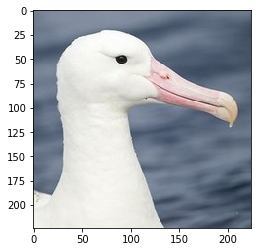

note that image array type is uint8
top-5 classes are:
0.996280	albatross
0.003715	goose
0.000001	drake
0.000001	white stork
0.000001	spoonbill


In [28]:
img = imread('albatross.jpg')
plt.imshow(img)
plt.show()
print("note that image array type is", img.dtype)

p = model.predict(<predict what???>)

labels = p.ravel().argsort()[-1:-6:-1]
print('top-5 classes are:')
for l in labels:
    print('%3f\t%s' % (p.ravel()[l], classes[l].split(',')[0]))

# Grand-quest: Dogs Vs Cats
* original competition
* https://www.kaggle.com/c/dogs-vs-cats
* 25k JPEG images of various size, 2 classes (guess what)

### Your main objective
* In this seminar your goal is to fine-tune a pre-trained model to distinguish between the two rivaling animals
* The first step is to just reuse some network layer as features

In [ ]:
!wget https://www.dropbox.com/s/d61lupw909hc785/dogs_vs_cats.train.zip?dl=1 -O data.zip
!unzip data.zip

# for starters
* Train sklearn model, evaluate validation accuracy (should be >80%

In [ ]:
#extract features from images
from tqdm import tqdm
from scipy.misc import imresize
import os
X = []
Y = []

#this may be a tedious process. If so, store the results in some pickle and re-use them.
for fname in tqdm(os.listdir('train/')):
    y = fname.startswith("cat")
    img = imread("train/"+fname)
    img = preprocess(imresize(img,(IMAGE_W,IMAGE_W)))
    features = <preprocess the image into features)
    Y.append(y)
    X.append(features)

In [ ]:

X = np.concatenate(X) #stack all [1xfeature] matrices into one. 
assert X.ndim==2
#WARNING! the concatenate works for [1xN] matrices. If you have other format, stack them yourself.

#crop if we ended prematurely
Y = Y[:len(X)]

In [ ]:
from sklearn.cross_validation import train_test_split

<split data either here or by cross-validation>

__load our dakka__
![img](https://s-media-cache-ak0.pinimg.com/564x/80/a1/81/80a1817a928744a934a7d32e7c03b242.jpg)

In [ ]:
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier,GradientBoostingClassifier,AdaBoostClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

# Main quest

* Get the score improved!

No methods are illegal: ensembling, data augmentation, NN hacks. 
Just don't let test data slip into training.

The main requirement is that you implement the NN fine-tuning recipe:
### Split the raw image data
  * please do train/validation/test instead of just train/test
  * reasonable but not optimal split is 20k/2.5k/2.5k or 15k/5k/5k
### Choose which vgg layers are you going to use
  * Anything but for prob is okay
  * Do not forget that vgg16 uses dropout
### Build a few layers on top of chosen "neck" layers.
  * a good idea is to just stack more layers inside the same network
  * alternative: stack on top of get_output
### Train the newly added layers for some iterations
  * you can selectively train some weights by only sending them to your optimizer
      * `mysupermegaoptimizer.minimize(loss, var_list=<only_those_weights_i_wanna_train>)`
  * it's cruicial to monitor the network performance at this and following steps
### Fine-tune the network body
  * probably a good idea to SAVE your new network weights now 'cuz it's easy to mess things up.
  * Moreover, saving weights periodically is a no-nonsense idea
  * even more cruicial to monitor validation performance
  * main network body may need a separate, much lower learning rate
      * You can have two optimizers: one for old network and one for new network
      * `old_net_optimizer.minimize(loss, old_net_weigts)`
      * `new_net_optimizer.minimize(loss, new_net_weigts)`
### PROFIT!!!
  * Evaluate the final score
  * Submit to kaggle
      * competition page https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition
      * get test data https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/data
  
## Some ways to get bonus points
* explore other networks from the model zoo
* play with architecture
* 85%/90%/93%/95%/97% kaggle score (screenshot pls).
* data augmentation, prediction-time data augmentation
* use any more advanced fine-tuning technique you know/read anywhere
* ml hacks that benefit the final score


In [ ]:
print("I can do it!")